In [24]:
# importing the libraries
import torch, torchvision, os, PIL, pdb

from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import glob
from PIL import Image, ExifTags
import colorsys
import random
import pylab
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.optim as optim
from tqdm.notebook import tqdm
import os
import random
from IPython import display
import ignite
from ignite.engine import Engine, Events
import ignite.distributed as idist
from ignite.metrics import FID, InceptionScore
from ignite.contrib.handlers import ProgressBar
import warnings

warnings.filterwarnings("ignore")

def show(tensor, num=25, wandbactive=0, name=''):
    data = tensor.detach().cpu()
    grid = make_grid(data[:num], nrow=5).permute(1,2,0)

    plt.imshow(grid.clip(0,1))
    plt.axis('off')
    plt.show()
    plt.axis('off')
    

In [25]:
### Global parameters
n_epochs=30
batch_size=64
image_size = 64
lr=2e-4
z_dim=100
device='cuda' #GPU
tag='DCGAN_cracks'
data_path='data_crops_cracks/crackSubImageForTraining/130BY130/accept'

### DC-GAN
show_step=100
save_step=100

In [26]:
# generator model
# https://medium.com/@ideami

class Generator(nn.Module):
    def __init__(self, z_dim=64, d_dim=16):
        super(Generator, self).__init__()
        self.z_dim=z_dim

        self.gen = nn.Sequential(
                ## ConvTranspose2d: in_channels, out_channels, kernel_size, stride=1, padding=0
                ## Calculating new width and height: (n-1)*stride -2*padding +ks
                ## n = width or height
                ## ks = kernel size
                ## we begin with a 1x1 image with z_dim number of channels (200)
                nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0, bias=False), ## 4x4 (ch: 200, 512)
                nn.BatchNorm2d(d_dim*32),
                nn.ReLU(True),

                nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1, bias=False), ## 8x8 (ch: 512, 256)
                nn.BatchNorm2d(d_dim*16),
                nn.ReLU(True),

                nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1, bias=False), ## 16x16 (ch: 256, 128)
                #(n-1)*stride -2*padding +ks = (8-1)*2-2*1+4=16
                nn.BatchNorm2d(d_dim*8),
                nn.ReLU(True),

                nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1, bias=False), ## 32x32 (ch: 128, 64)
                nn.BatchNorm2d(d_dim*4),
                nn.ReLU(True),            

                nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1, bias=False), ## 64x64 (ch: 64, 32)
                nn.BatchNorm2d(d_dim*2),
                nn.ReLU(True),            

                nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1, bias=False), ## 128x128 (ch: 32, 3)
                nn.Tanh() ### produce result in the range from -1 to 1
        )


    def forward(self, noise):
        x=noise.view(len(noise), self.z_dim, 1, 1)  # 128 x 200 x 1 x 1
        return self.gen(x)

class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # final state size. 3 x 64 x 64
        )

    def forward(self, noise):
        x = self.model(noise.view(len(noise), self.z_dim, 1, 1))
        return x
    
    
def gen_noise(num, z_dim, device='cuda'):
    return torch.randn(num, z_dim, device=device) # 128 x 200



In [27]:
## critic model

class Critic(nn.Module):
    def __init__(self, d_dim=16):
        super(Critic, self).__init__()

        self.crit = nn.Sequential(
          # Conv2d: in_channels, out_channels, kernel_size, stride=1, padding=0
          ## New width and height: # (n+2*pad-ks)//stride +1
          nn.Conv2d(3, d_dim, 4, 2, 1, bias=False), #(n+2*pad-ks)//stride +1 = (128+2*1-4)//2+1=64x64 (ch: 3,16)
          nn.InstanceNorm2d(d_dim), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim, d_dim*2, 4, 2, 1, bias=False), ## 32x32 (ch: 16, 32)
          nn.InstanceNorm2d(d_dim*2), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1, bias=False), ## 16x16 (ch: 32, 64)
          nn.InstanceNorm2d(d_dim*4), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1, bias=False), ## 8x8 (ch: 64, 128)
          nn.InstanceNorm2d(d_dim*8), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1, bias=False), ## 4x4 (ch: 128, 256)
          nn.InstanceNorm2d(d_dim*16), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim*16, 1, 4, 1, 0, bias=False), #(n+2*pad-ks)//stride +1=(4+2*0-4)//1+1= 1X1 (ch: 256,1)
          nn.Sigmoid()
        )


    def forward(self, image):
        # image: 128 x 3 x 128 x 128
        crit_pred = self.crit(image) # 128 x 1 x 1 x 1
        return crit_pred.view(len(crit_pred),-1) ## 128 x 1  

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

# Optimizers

In [28]:
gen = Generator(z_dim=z_dim).to(device)
crit = Critic().to(device)
# Loss
criterion = nn.BCELoss()

# Different optimizer options for generator and discriminator
crit_opt = optim.Adam(crit.parameters(), lr=lr, betas=(0.5, 0.999))
gen_opt = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

# DataLoader

In [29]:
## optional, init your weights in different ways
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)

    if isinstance(m,nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias,0)

In [30]:
class image_loader(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=''):
        'Initialization'
        self.transform = transform
        self.image_paths = glob.glob(data_path+'/*.jpg')
        if train:
            self.image_paths = self.image_paths[0:int(0.9*len(self.image_paths))]
        else:
            self.image_paths = self.image_paths[int(0.9*len(self.image_paths)):]
        self.labels_dict = {"accept":0}
        self.inv_labels_dict = {v: k for k, v in self.labels_dict.items()}
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        
        X = self.transform(image)
        y = self.labels_dict[image_path.split("/")[-2]]
        
        return X, y


train_transform = transforms.Compose([transforms.Resize((image_size, image_size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                                    )

trainset = image_loader(train=True, transform=train_transform,
                        data_path=data_path)
train_dataloader = DataLoader(trainset, shuffle=True, batch_size=batch_size,
                              num_workers=12, drop_last=True)

testset = image_loader(train=False, transform=train_transform,
                       data_path=data_path)
test_dataloader = DataLoader(testset, batch_size=batch_size,
                             num_workers=12, drop_last=True)

Train set length:  7555
Test set length:  840


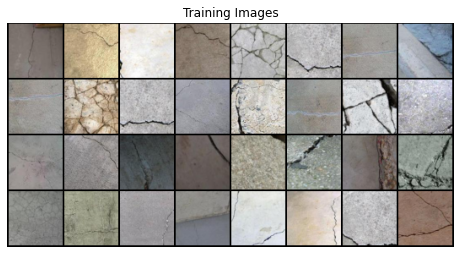

In [31]:
print("Train set length: ", len(train_dataloader.dataset))
print("Test set length: ", len(test_dataloader.dataset))


real_batch = next(iter(train_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:32], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Evaluation metrics

In [32]:
fid_metric = FID(device=device)
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

In [33]:
## Interpolate dataset images to 299x299x3 to be able to work with IS and FID prebuilt functions
def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

## Apply interpolation to fake and real batch images
def evaluation_step(Engine, batch):
    with torch.no_grad():
        noise = gen_noise(len(batch[0]), z_dim)
        gen.eval()
        fake_batch = gen(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

In [34]:
evaluator = Engine(evaluation_step)
is_metric.attach(evaluator, "is")
fid_metric.attach(evaluator, "fid")

# Training

In [35]:
def training_losses(gen_losses, crit_losses, cur_step, show_step):
    gen_mean=sum(gen_losses[-show_step:]) / show_step
    crit_mean = sum(crit_losses[-show_step:]) / show_step
    print(f"Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean:4f}, critic loss: {crit_mean:4f}")
    

In [36]:
def evaluate_fid_is():
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")

In [37]:
## Save and load checkpoints

if not os.path.exists(f'./info/{tag}/'):
    os.mkdir(f'./info/{tag}/')
root_path=f'./info/{tag}/'

def save_checkpoint(name):
    torch.save({
      'epoch': epoch,
      'gen_losses': gen_losses,
      'crit_losses': crit_losses,
      'fids': evaluator.state.metrics['fid'],
      'iss': evaluator.state.metrics['is'],        
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict()      
    }, f"{root_path}G-{name}.pkl")

    torch.save({
      'epoch': epoch,
      'crit_losses': crit_losses,
      'fids': evaluator.state.metrics['fid'],
      'iss': evaluator.state.metrics['is'],
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()      
    }, f"{root_path}C-{name}.pkl")
  
    print("Saved checkpoint")

def load_checkpoint(name):
    checkpoint = torch.load(f"{root_path}G-{name}.pkl")
    gen.load_state_dict(checkpoint['model_state_dict'])
    gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    checkpoint = torch.load(f"{root_path}C-{name}.pkl")
    crit.load_state_dict(checkpoint['model_state_dict'])
    crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    print("Loaded checkpoint")

#load_checkpoint('final-wgan-noinit')

  0%|          | 0/118 [00:00<?, ?it/s]

*   FID : 0.090629
*    IS : 1.324200


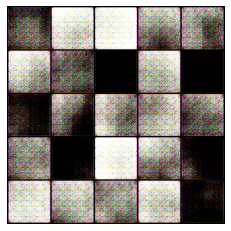

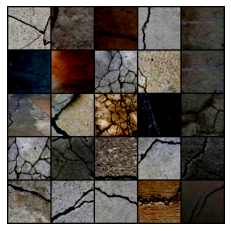

Epoch: 0: Step 100: Generator loss: 8.043261, critic loss: 0.521644
Saving checkpoint:  100 100
Saved checkpoint


  0%|          | 0/118 [00:00<?, ?it/s]

*   FID : 0.111770
*    IS : 1.223297


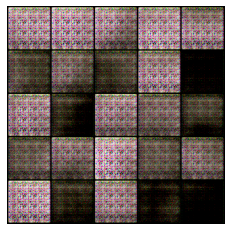

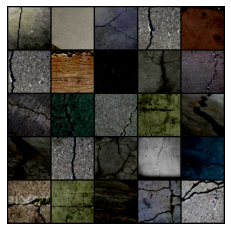

Epoch: 1: Step 200: Generator loss: 4.355585, critic loss: 0.576553
Saving checkpoint:  200 100
Saved checkpoint


  0%|          | 0/118 [00:00<?, ?it/s]

KeyboardInterrupt: 

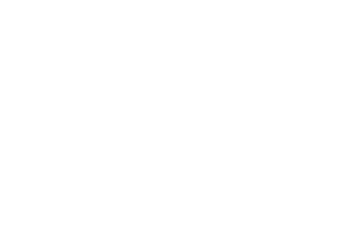

In [38]:
## Training loop 
gen_losses=[]
crit_losses=[]
cur_step=0
real_label = 1
fake_label = 0
for epoch in range(n_epochs):
    for real, _ in tqdm(train_dataloader):
        cur_bs= len(real) #128
        real=real.to(device)
        crit_opt.zero_grad()
        # Format batch
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output1 = crit(real).view(-1)
        # Calculate loss on all-real batch
        crit_loss_real = criterion(output1, label)
        # Calculate gradients for D in backward pass
        crit_loss_real.backward()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output2 = crit(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        crit_loss_fake = criterion(output2, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        crit_loss_fake.backward()
        # Compute error of D as sum over the fake and the real batches
        crit_loss = crit_loss_real + crit_loss_fake
        # Update D
        crit_opt.step()
        
        crit_losses += [crit_loss.item()]

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen_opt.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output3 = crit(fake).view(-1)
        # Calculate G's loss based on this output
        gen_loss = criterion(output3, label)
        # Calculate gradients for G
        gen_loss.backward()
        # Update G
        gen_opt.step()
        
        gen_losses+=[gen_loss.item()]

        ### STATS  
        if (cur_step % show_step == 0 and cur_step > 0):
            evaluate_fid_is()
            show(fake, wandbactive=1, name='fake')
            show(real, wandbactive=1, name='real')
            training_losses(gen_losses, crit_losses, cur_step, show_step)
            
            print("Saving checkpoint: ", cur_step, save_step)
            save_checkpoint("latest")

        cur_step+=1


In [ ]:
#### Generate new faces
noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

In [ ]:
plt.imshow(fake[16].detach().cpu().permute(1,2,0).squeeze().clip(0,1))

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

# MORPHING, interpolation between points in latent space
gen_set=[]
z_shape=[1,200,1,1]
rows=4
steps=17

for i in range(rows):
  z1,z2 = torch.randn(z_shape), torch.randn(z_shape)
  for alpha in np.linspace(0,1,steps):
    z=alpha*z1 + (1-alpha)*z2
    res=gen(z.cuda())[0]
    gen_set.append(res)

fig = plt.figure(figsize=(25,11))
grid=ImageGrid(fig, 111, nrows_ncols=(rows,steps), axes_pad=0.1)

for ax , img in zip (grid, gen_set):
  ax.axis('off')
  res=img.cpu().detach().permute(1,2,0)
  res=res-res.min()
  res=res/(res.max()-res.min())
  ax.imshow(res.clip(0,1.0))

plt.show()